In [128]:
import music21
from music21 import *

import IPython
from IPython.display import display, Image
import midi2audio
import io
import mido

from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

from keras.layers import LSTM, Input, Dropout, Dense, Activation, Embedding, Concatenate, Reshape
from keras.layers import Flatten, RepeatVector, Permute, TimeDistributed
from keras.layers import Multiply, Lambda, Softmax
import keras.backend as K
from keras.models import Model
from tensorflow.keras.optimizers import RMSprop

from sklearn.model_selection import train_test_split

from keras.utils import to_categorical

import seaborn as sns

In [137]:
import os

#get all the midi files
all_midis = []
files = os.listdir("C:\\Users\\Eric Kuo\\Documents\\Pokemon_Town")

for file in files:
    print("File:", file)
    file_path = f'Documents/Pokemon_Town/{file}'
    try:
        midi = converter.parse(file_path)
        all_midis.append(midi)
    except Exception as e:
        print("Error processing file:", file_path)
        print("Exception:", str(e))
print("all done!")

File: Accumula Town.mid
File: Amity Square.mid
File: Anville Town.mid
File: Asperita City.mid
File: Azalea Town.mid
File: Battle Castle.mid
File: Battle Hall.mid
File: Bicycle Ride.mid
File: Black City.mid
File: Canalave City (Night).mid
File: Canalave City.mid
File: Castelia City.mid
File: Celadon City.mid
File: celadon-city.mid
File: Cerulean City.mid
File: cerulean-city-3-.mid
File: Cherrygrove City.mid
File: Cianwood City.mid
File: Cinnabar Island.mid
File: desktop.ini
Error processing file: Documents/Pokemon_Town/desktop.ini
Exception: cannot find a format extensions for: C:\Users\Eric Kuo\Documents\Pokemon_Town\desktop.ini
File: dewford-town-2-.mid
File: Driftveil City.mid
File: Ecruteak City.mid
File: Epilogue.mid
File: Eterna City (Night).mid
File: Eterna City.mid
File: Eterna Forest.mid
File: fallarbor-town.mid
File: Floaroma Town (Night).mid
File: Floaroma Town.mid
File: Flocessy Town.mid
File: fortree-city.mid
File: geosengetown.mid
File: Goldenrod City.mid
File: Hearthome C

In [138]:
#Determine Melody
def identify_melody(midi_file):
  max_combination = 0

  for part in midi_file.parts:

    velocity_sum = 0
    num_notes = 0
    average_velocity = 0
    total_pitch = 0

    for note in part.flat.notes:
      velocity = note.volume.velocity
      velocity_sum += velocity
      num_notes += 1

      try:
        pitch = note.pitch.ps
        total_pitch += pitch
      except:
        pass

    if num_notes > 0:
      average_velocity = velocity_sum / num_notes
      average_pitch = total_pitch / num_notes
      combination = average_velocity + average_pitch

      if combination > max_combination:
        max_combination = combination
        melody = part

  return melody

In [139]:
def extract_melody(file):
  all_notes = []
  durations = []
  for midi_score in file:
    melody_part = identify_melody(midi_score)

    # Iterate through the elements of the midi_score
    for element in melody_part.flat.notes:
      # Check if the element is a note
      if isinstance(element, note.Note):
          # Append the note and durations to lists
          note_name = element.nameWithOctave
          all_notes.append(note_name)
          durations.append(element.duration.quarterLength)
  return all_notes, durations

all_melodies, durations = extract_melody(all_midis)

#make sure they number of notes and their durations match
print("Total notes in all Pokemon dataset:", len(all_melodies))
print(len(durations))

C:\Users\Eric Kuo\anaconda3\lib\music21\stream\base.py:3694: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)


Total notes in all Pokemon dataset: 17319
17319


In [140]:
#set lilypond path for music21 environment
music21.environment.set('lilypondPath', 'C:\\Program Files (x86)\\LilyPond\\usr\\bin\\lilypond.exe')

def show(music):
    display(Image(str(music.write("lily.png"))))
    
def play(midi_stream):
    # Play the MIDI stream
    midi_stream.show('midi')


In [141]:
#view some information on the dataset
print("First fifty values in the Pokemon dataset:", all_melodies[:50])
print("First fifty note durations in the Pokemon dataset:", durations[:50])

count_num = Counter(all_melodies)
print()
print("Number of unique Notes: ", len(count_num))

#Exploring the notes dictionary
Notes = list(count_num.keys())
Recurrence = list(count_num.values())
#Average recurrence for a note in Corpus
def Average(lst):
    return sum(lst) / len(lst)
print("Average recurrence for a note:", Average(Recurrence))
print("Most frequent note appeared:", max(Recurrence), "times")
print("Least frequent note appeared:", min(Recurrence), "time")

First fifty values in the Pokemon dataset: ['G#5', 'A5', 'B5', 'A5', 'G#5', 'E5', 'C#5', 'E5', 'C#5', 'C#5', 'E5', 'G#5', 'A5', 'G#5', 'F#5', 'F#5', 'E-5', 'E5', 'E5', 'G#5', 'A5', 'B5', 'A5', 'G#5', 'E5', 'C#5', 'E5', 'C#5', 'C#5', 'E5', 'G#5', 'A5', 'G#5', 'F#5', 'F#5', 'B5', 'E5', 'E5', 'E6', 'E6', 'E6', 'E-5', 'E5', 'C#5', 'E5', 'B5', 'A5', 'G#5', 'B5', 'G#5']
First fifty note durations in the Pokemon dataset: [0.25, 0.25, 0.25, 0.25, 0.75, 0.25, 0.75, 0.25, 0.5, 0.75, Fraction(1, 3), 0.25, 0.5, 0.25, 0.25, 0.25, Fraction(1, 3), 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.75, 0.25, 0.75, 0.25, 0.5, 0.75, Fraction(1, 3), 0.25, 0.5, 0.25, 0.25, 0.25, Fraction(1, 3), 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.5, 1.5, 0.25, 0.5, 0.5, 0.25, 0.5, 1.0]

Number of unique Notes:  74
Average recurrence for a note: 234.04054054054055
Most frequent note appeared: 1026 times
Least frequent note appeared: 1 time


In [142]:
#Look at sheet music of melody
def notes(Snippet, durationSnippet):
    Melody_stream = stream.Stream()
    offset = 0 #Incremental
    for i in range(len(Snippet)):
      note_snip = note.Note(Snippet[i])
      note_snip.duration.quarterLength = durationSnippet[i]
      Melody_stream.append(note_snip)

    return Melody_stream

#pick any interval within length
Melody_Snippet = notes(all_melodies[500:1000], durations[500:1000])
#show(Melody_Snippet)
play(Melody_Snippet)

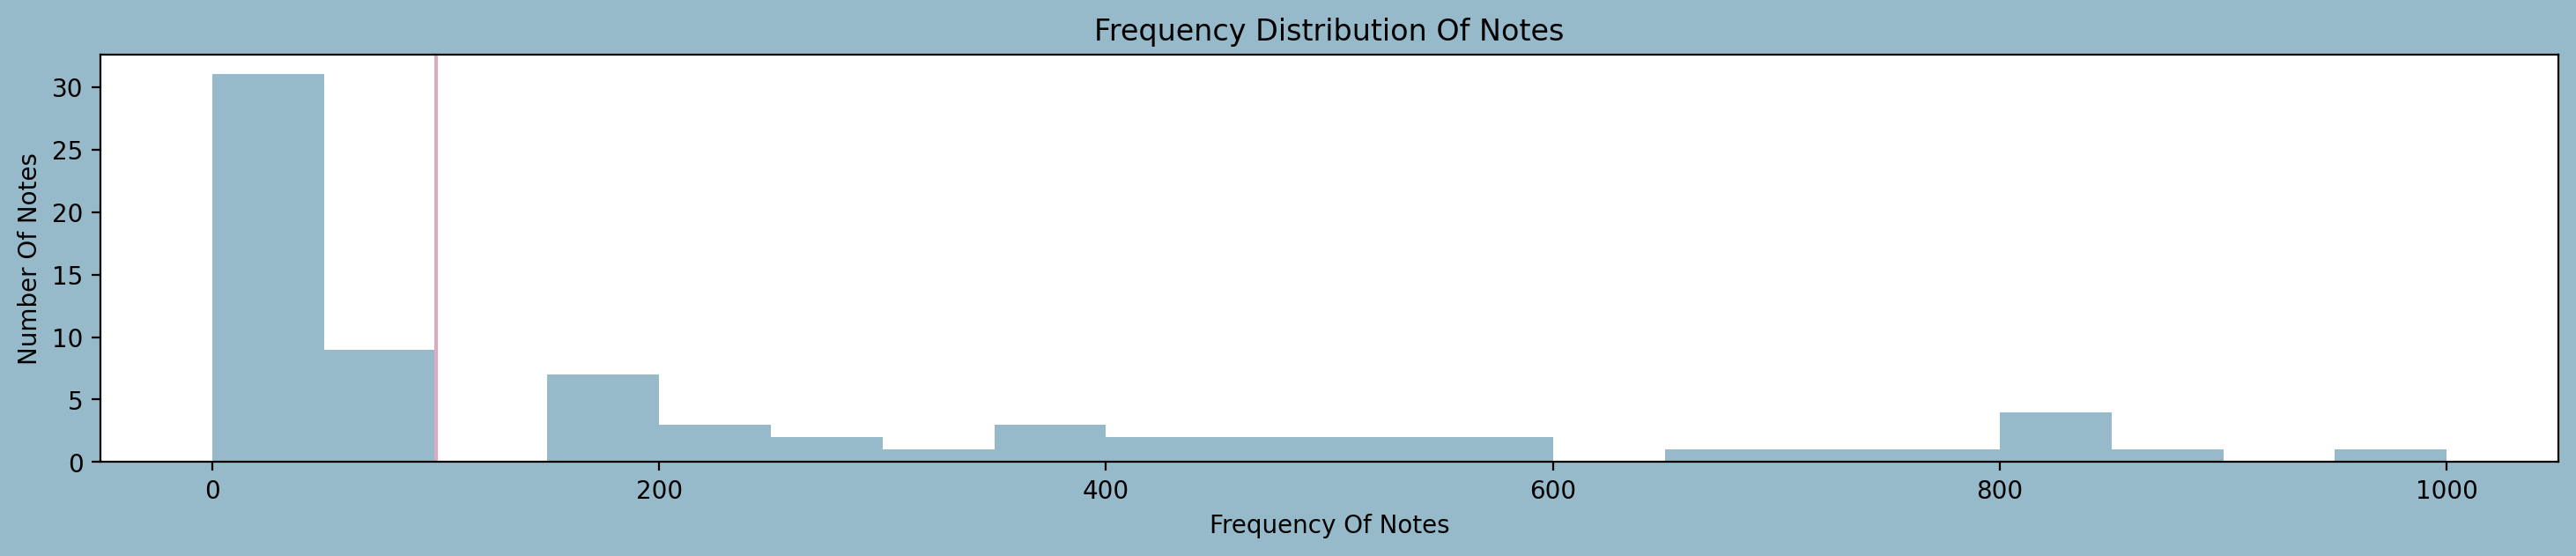

In [143]:
# Plotting the distribution of Notes
plt.figure(figsize=(18,3),facecolor="#97BACB")
bins = np.arange(0,(max(Recurrence)), 50)
plt.hist(Recurrence, bins=bins, color="#97BACB")
plt.axvline(x=100,color="#DBACC1")
plt.title("Frequency Distribution Of Notes")
plt.xlabel("Frequency Of Notes")
plt.ylabel("Number Of Notes")
plt.show()

In [144]:
#Dictionary to map notes and durations to integers
unique_notes = sorted(set(all_melodies))
unique_durations = sorted(set(durations))

note_to_int = dict((note, number) for number, note in enumerate(unique_notes))
duration_to_int = dict((duration, number) for number, duration in enumerate(unique_durations))
int_to_note = {number: note for note, number in note_to_int.items()}
int_to_duration = {number: duration for duration, number in duration_to_int.items()}

note_sequence = [note_to_int[note] for note in all_melodies]
duration_sequence = [duration_to_int[duration] for duration in durations]

L_melodies = len(note_sequence)
L_durations = len(duration_sequence)
L_unique_notes = len(unique_notes)
L_unique_durations = len(unique_durations)

print("Total number of characters:", L_melodies)
print("Total number of durations:", L_durations)
print("Number of unique characters:", L_unique_notes)
print("Number of unique durations:", L_unique_durations)

Total number of characters: 17319
Total number of durations: 17319
Number of unique characters: 74
Number of unique durations: 32


In [145]:
#test int back to note/duration
print(int_to_note[20])

C#3


In [146]:
#Splitting up Melodies to length of input and output target
sequence_length = 40
input_notes = []
input_durations = []
output_notes = []
output_durations = []

for i in range(len(note_sequence) - sequence_length):
  note_in = note_sequence[i:i+sequence_length]
  duration_in = duration_sequence[i:i+sequence_length]

  note_out = note_sequence[i+sequence_length]
  duration_out = duration_sequence[i+sequence_length]

  input_notes.append(note_in)
  input_durations.append(duration_in)
  output_notes.append(note_out)
  output_durations.append(duration_out)

n_patterns = len(input_notes)

input_notes = np.reshape(input_notes, (n_patterns, sequence_length))
input_durations = np.reshape(input_durations, (n_patterns, sequence_length))
network_input = [input_notes, input_durations]

output_notes = to_categorical(output_notes, num_classes=L_unique_notes)
output_durations = to_categorical(output_durations, num_classes=L_unique_durations)
network_output = [output_notes, output_durations]

print(input_notes[:1000])

[[66  4 16 ... 47 48 48]
 [ 4 16  4 ... 48 48 48]
 [16  4 66 ... 48 48 41]
 ...
 [71  3  3 ... 35 28  9]
 [ 3  3 71 ... 28  9  3]
 [ 3 71  3 ...  9  3 28]]


In [147]:
#Creating Neural Network
#Model taken from https://www.kaggle.com/code/ohseokkim/music-generation-let-s-enjoy-new-music
def create_network(n_notes, n_durations, embed_size=100, rnn_units=256, use_attention=False):
  # Define input layers for notes and durations
    notes_in = Input(shape=(None,))
    durations_in = Input(shape=(None,))

    # Embedding layers for notes and durations
    x1 = Embedding(n_notes, embed_size)(notes_in)
    x2 = Embedding(n_durations, embed_size)(durations_in)

    # Concatenate the embeddings of notes and durations
    x = Concatenate()([x1, x2])

    # LSTM layer
    x = LSTM(rnn_units, return_sequences=True)(x)

    # Attention mechanism (if specified)
    if use_attention:
        x = LSTM(rnn_units, return_sequences=True)(x)
        e = Dense(1, activation='tanh')(x)
        e = Reshape([-1])(e)
        alpha = Activation('softmax')(e)
        alpha_repeated = Permute([2, 1])(RepeatVector(rnn_units)(alpha))
        c = Multiply()([x, alpha_repeated])
        c = Lambda(lambda xin: K.sum(xin, axis=1), output_shape=(rnn_units,))(c)
    else:
        c = LSTM(rnn_units)(x)

    # Output layers for notes and durations
    notes_out = Dense(n_notes, activation='softmax', name='pitch')(c)
    durations_out = Dense(n_durations, activation='softmax', name='duration')(c)

    # Create the model with inputs and outputs
    model = Model(inputs=[notes_in, durations_in], outputs=[notes_out, durations_out])

    # Create attention model (if specified)
    if use_attention:
        att_model = Model(inputs=[notes_in, durations_in], outputs=alpha)
    else:
        att_model = None

    # Compile the model with loss and optimizer
    opti = RMSprop(lr=0.001)
    model.compile(loss=['categorical_crossentropy', 'categorical_crossentropy'], optimizer=opti)

    # Return the model and attention model
    return model, att_model

In [22]:
sequence_length = 40
embed_size = 100
rnn_units = 256
use_attention = True

model, att_model = create_network(L_unique_notes, L_unique_durations, embed_size, rnn_units, use_attention)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, None, 100)            7400      ['input_1[0][0]']             
                                                                                                  
 embedding_1 (Embedding)     (None, None, 100)            3200      ['input_2[0][0]']             
                                                                                              

In [23]:
#split data into training and validation sets
#train_input, val_input, train_output, val_output = train_test_split(network_input, network_output, test_size=0.2, random_state=42)
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define the paths to save the best model
checkpoint_filepath = 'best_model.h5'

# Define the callbacks
checkpoint_callback = ModelCheckpoint(checkpoint_filepath, monitor='val_pitch_loss', save_best_only=True, mode='min')
early_stopping_callback = EarlyStopping(monitor='val_pitch_loss', patience=5, mode='min')


#Train the model
history = model.fit(
    network_input,
    network_output,
    validation_split = 0.2,
    batch_size=32,
    epochs=50
)


Epoch 1/50
432/432 [==============================] - 85s 192ms/step - loss: 5.1680 - pitch_loss: 3.4781 - duration_loss: 1.6899 - val_loss: 5.3494 - val_pitch_loss: 3.4355 - val_duration_loss: 1.9139
Epoch 2/50
432/432 [==============================] - 80s 186ms/step - loss: 4.5812 - pitch_loss: 3.0672 - duration_loss: 1.5140 - val_loss: 5.1534 - val_pitch_loss: 3.3661 - val_duration_loss: 1.7873
Epoch 3/50
432/432 [==============================] - 82s 190ms/step - loss: 4.3288 - pitch_loss: 2.8822 - duration_loss: 1.4466 - val_loss: 5.0980 - val_pitch_loss: 3.3045 - val_duration_loss: 1.7935
Epoch 4/50
432/432 [==============================] - 83s 192ms/step - loss: 4.1594 - pitch_loss: 2.7644 - duration_loss: 1.3949 - val_loss: 5.1589 - val_pitch_loss: 3.3222 - val_duration_loss: 1.8367
Epoch 5/50
432/432 [==============================] - 83s 191ms/step - loss: 4.0159 - pitch_loss: 2.6618 - duration_loss: 1.3541 - val_loss: 5.1292 - val_pitch_loss: 3.3094 - val_duration_loss: 1.

C:\Users\Eric Kuo\anaconda3\lib\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [38]:
#train model for more epochs
#Train the model
history2 = model.fit(
    network_input,
    network_output,
    validation_split = 0.2,
    batch_size=32,
    epochs=50
)

Epoch 1/50
432/432 [==============================] - 77s 178ms/step - loss: 0.6733 - pitch_loss: 0.4544 - duration_loss: 0.2189 - val_loss: 10.7544 - val_pitch_loss: 6.7243 - val_duration_loss: 4.0301
Epoch 2/50
432/432 [==============================] - 77s 177ms/step - loss: 0.6377 - pitch_loss: 0.4271 - duration_loss: 0.2106 - val_loss: 10.5478 - val_pitch_loss: 6.6471 - val_duration_loss: 3.9007
Epoch 3/50
432/432 [==============================] - 77s 177ms/step - loss: 0.6281 - pitch_loss: 0.4216 - duration_loss: 0.2064 - val_loss: 10.8709 - val_pitch_loss: 6.8301 - val_duration_loss: 4.0408
Epoch 4/50
432/432 [==============================] - 78s 182ms/step - loss: 0.6140 - pitch_loss: 0.4122 - duration_loss: 0.2018 - val_loss: 11.0464 - val_pitch_loss: 6.9042 - val_duration_loss: 4.1422
Epoch 5/50
432/432 [==============================] - 76s 176ms/step - loss: 0.5837 - pitch_loss: 0.3871 - duration_loss: 0.1966 - val_loss: 11.0772 - val_pitch_loss: 6.9004 - val_duration_los

In [39]:
model.save('my_model.keras')

[Text(0.5, 0, 'Epochs')]

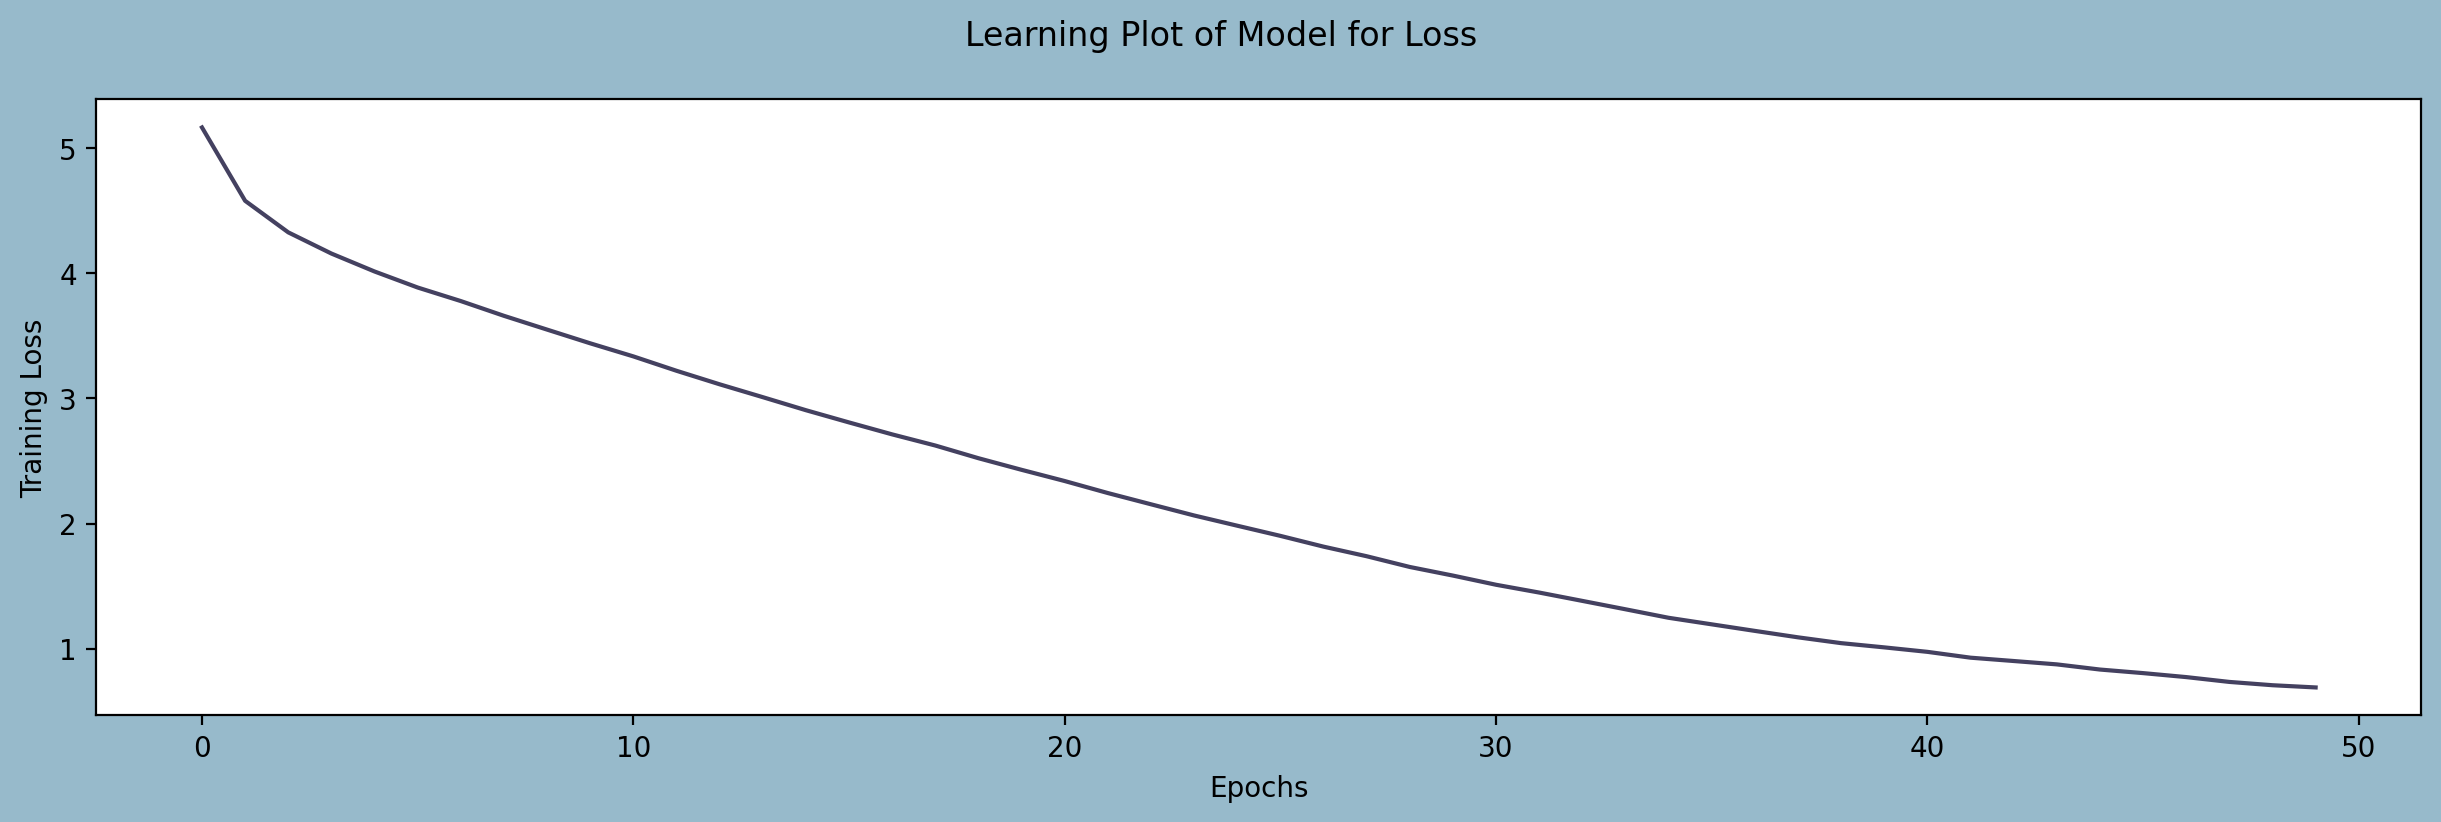

In [136]:
#Plotting the learnings 
history_df = pd.DataFrame(history.history)
fig = plt.figure(figsize=(15,4), facecolor="#97BACB")
fig.suptitle("Learning Plot of Model for Loss")
pl=sns.lineplot(data=history_df["loss"],color="#444160")
pl.set(ylabel ="Training Loss")
pl.set(xlabel ="Epochs")

In [134]:
import numpy as np

#example input to start off predictions
file_path = f'Downloads/Alabaster_Icelands_1_Pokemon_Legends_Arceus.mid'
midi = converter.parse(file_path)
melody = identify_melody(midi)

ex_notes, ex_durations = extract_melody([midi])

input_notes = ex_notes[:40]
input_durations = ex_durations[:40]

input_notes = [note_to_int[note] for note in input_notes]
input_durations = [duration_to_int[duration] for duration in input_durations]

print(input_notes)

# Generate the desired number of notes
desired_length = 200

generated_notes_int = []
generated_durations_int = []

for _ in range(desired_length):
    # Reshape the input sequence for prediction
    input_notes_array = np.array(input_notes[-40:-1]).reshape(1, -1)
    input_durations_array = np.array(input_durations[-40:-1]).reshape(1, -1)

    # Make predictions
    predictions = model.predict([input_notes_array, input_durations_array])

    # Sample the next note from the predictions
    next_note = np.argmax(predictions[0][-1])
    next_duration = np.argmax(predictions[1][-1])

    # Append the next note and duration to the input sequence
    input_notes.append(next_note)
    input_durations.append(next_duration)
    
    generated_notes_int.append(next_note)
    generated_durations_int.append(next_duration)
                                     

# Convert the generated notes back to their original representations
generated_notes = [int_to_note[note] for note in generated_notes_int]
generated_durations = [int_to_duration[duration] for duration in generated_durations_int]

print(generated_notes)

# Process the generated notes and durations as needed
# ...

[15, 53, 15, 53, 15, 22, 35, 22, 22, 15, 9, 15, 53, 46, 34, 14, 34, 46, 53, 46, 46, 14, 46, 34, 34, 3, 3, 3, 71, 46, 46, 34, 2, 3, 3, 3, 71, 53, 53, 46]
1/1 [==============================] - 0s 26ms/step
['C#5', 'A4', 'A4', 'B4', 'B4', 'F#5', 'A4', 'F#5', 'D4', 'D5', 'D5', 'B4', 'A4', 'D5', 'G2', 'A4', 'G3', 'A4', 'A4', 'D5', 'G2', 'D5', 'A4', 'A3', 'D5', 'C6', 'B4', 'G4', 'D4', 'D4', 'A4', 'G2', 'A4', 'A4', 'E-4', 'A4', 'A4', 'A4', 'A4', 'D4', 'C#5', 'F4', 'A4', 'G3', 'A4', 'G3', 'A4', 'A4', 'A4', 'A4', 'D5', 'D4', 'D4', 'D6', 'D5', 'D4', 'C5', 'D5', 'D5', 'B4', 'C5', 'B4', 'A4', 'A4', 'C5', 'A3', 'B4', 'C5', 'D4', 'C5', 'D5', 'D4', 'D4', 'D5', 'G3', 'E5', 'D5', 'C5', 'C5', 'E4', 'D5', 'C5', 'D5', 'D5', 'D5', 'D5', 'D5', 'G4', 'C5', 'E5', 'G4', 'E5', 'C5', 'C5', 'E5', 'C5', 'E-5', 'G4', 'G4', 'G4', 'G4', 'G4', 'E-5', 'C5', 'C5', 'G4', 'A5', 'G4', 'G4', 'E-5', 'G4', 'G4', 'F#5', 'F#5', 'D5', 'G4', 'G4', 'G4', 'G4', 'F#5', 'G#5', 'D5', 'F#5', 'D5', 'F#5', 'D5', 'D5', 'D5', 'C5', 'C5', 

In [135]:
generated_melody = notes(generated_notes, generated_durations)

play(generated_melody)